# Τελική Άσκηση

## Παναγιώτης Τσιάβος 2396

In [1]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image


import tensorflow as tf
import numpy as np

## Μέρος 1ο - Σημασιολογική κατάτμηση

Αρχικά ορίζουμε μια κλάση DeepLabModel που παίρνει ως είσοδο ενα απο τα έτοιμα μοντέλα του Deeplab, (model name: mobilenetv2_coco_voctrainval).

In [2]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

Φορτώνουμε ένα απο τα έτοιμα μοντέλα του Deeplab και αρχικοποιούμε την κλάση.

In [3]:
MODEL_NAME = 'mobilenetv2_coco_voctrainval'

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


Θέτουμε ως είσοδο την εικόνα στο νευρωνικό δίκτυο χρησιμοποιώντας την μέθοδο .run() της κλάσης η οποία μας επιστρέφει το επιθυμητό output_layer.  
Τέλος καλούμε την συνάρτηση vis_segmentation() για να οπτικοποιήσουμε το αποτέλεσμα.

In [4]:
def run_visualization(imgpath):
  """Inferences DeepLab model and visualizes result."""
  try:
    original_im = Image.open(imgpath)
  except IOError:
    print('Cannot retrieve image. Please check path: ' + imgpath)
    return

  print('running deeplab on image %s...' % imgpath)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)

running deeplab on image horse.png...


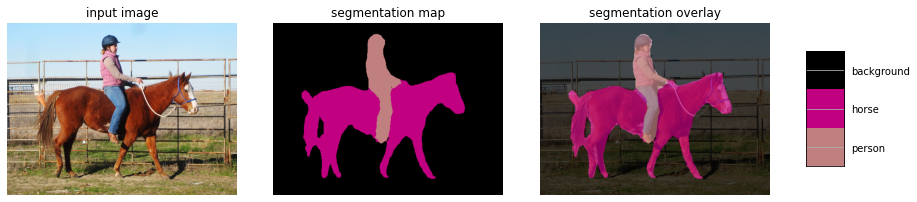

In [5]:
run_visualization('horse.png')

running deeplab on image planestrains.jpg...


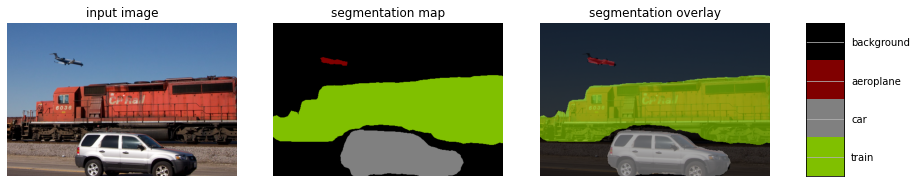

In [6]:
run_visualization('planestrains.jpg')

running deeplab on image drink.jpg...


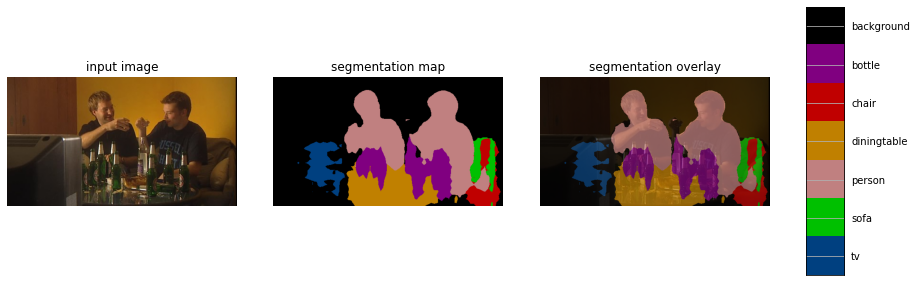

In [7]:
run_visualization('drink.jpg')

running deeplab on image catdog.jpg...


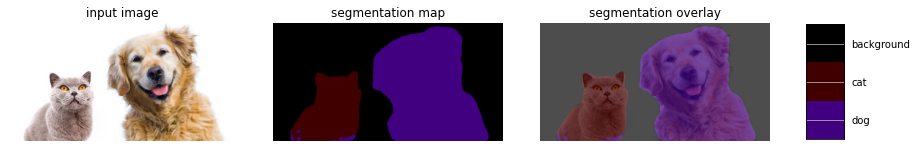

In [8]:
run_visualization('catdog.jpg')

running deeplab on image boat.jpg...


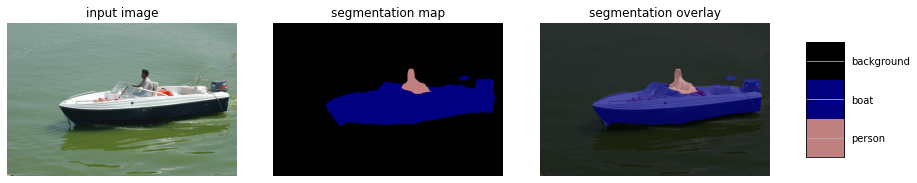

In [9]:
run_visualization('boat.jpg')

## Μέρος 2ο - PCA

Αρχικά βρίσκουμε ένα κατάλληλο ενδιάμεσο στρώμα του δικτύου.  
Έπειτα εκτελούμε Principal Component Analysis (PCA) ( function run_pca()) στα βαθιά χαρακτηριστικά ώστε να ’ρίξουμε’ την διάσταση τους σε n = 3, και οπτικοποιούμε το αποτέλεσμα μεταχειρίζοντάς το σαν να ήταν μια έγχρωμη εικόνα (function visual_pca()). 

In [10]:
from sklearn.decomposition import PCA

In [11]:
for op in MODEL.graph.get_operations():
    print(op.outputs)


[<tf.Tensor 'ImageTensor:0' shape=(1, ?, ?, 3) dtype=uint8>]
[<tf.Tensor 'Shape:0' shape=(4,) dtype=int32>]
[<tf.Tensor 'strided_slice/stack:0' shape=(1,) dtype=int32>]
[<tf.Tensor 'strided_slice/stack_1:0' shape=(1,) dtype=int32>]
[<tf.Tensor 'strided_slice/stack_2:0' shape=(1,) dtype=int32>]
[<tf.Tensor 'strided_slice:0' shape=(2,) dtype=int32>]
[<tf.Tensor 'Squeeze:0' shape=(?, ?, 3) dtype=uint8>]
[<tf.Tensor 'Cast:0' shape=(?, ?, 3) dtype=float32>]
[<tf.Tensor 'ToFloat/x:0' shape=() dtype=float32>]
[<tf.Tensor 'Shape_1:0' shape=(3,) dtype=int32>]
[<tf.Tensor 'strided_slice_1/stack:0' shape=(1,) dtype=int32>]
[<tf.Tensor 'strided_slice_1/stack_1:0' shape=(1,) dtype=int32>]
[<tf.Tensor 'strided_slice_1/stack_2:0' shape=(1,) dtype=int32>]
[<tf.Tensor 'strided_slice_1:0' shape=() dtype=int32>]
[<tf.Tensor 'strided_slice_2/stack:0' shape=(1,) dtype=int32>]
[<tf.Tensor 'strided_slice_2/stack_1:0' shape=(1,) dtype=int32>]
[<tf.Tensor 'strided_slice_2/stack_2:0' shape=(1,) dtype=int32>]
[<

In [12]:
# Choosing a layer
MODEL.OUTPUT_TENSOR_NAME = "aspp0/Conv2D:0"

In [13]:
def run_pca(deepfeats, n):
    N = deepfeats.shape[0]*deepfeats.shape[1]
    C = deepfeats.shape[-1]
    X = np.reshape(deepfeats, [N, C])
    print('Shape before PCA: {}'.format(X.shape))
    Xreduced = PCA(n_components=n).fit_transform(X)
    print('Shape after PCA: {}'.format(Xreduced.shape))
    
    deepfeats_reduced = np.reshape(Xreduced, [deepfeats.shape[0], deepfeats.shape[1], n])
    print(deepfeats_reduced.shape)
    
    return deepfeats_reduced
    

In [14]:
def visual_pca(ri, deepfeats_reduced):
    plt.imshow(deepfeats_reduced)
    plt.show()    
    plt.imshow(ri)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape before PCA: (4225, 256)
Shape after PCA: (4225, 3)
(65, 65, 3)


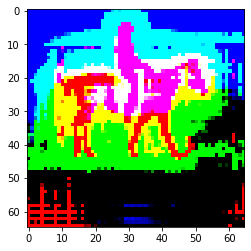

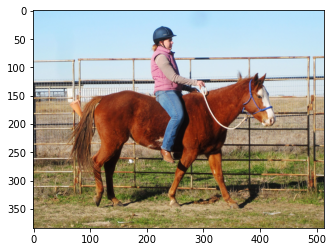

In [15]:
# Run the model to get the chosen layer
ri, deepfeats = MODEL.run(Image.open('horse.png'))
deepfeats_reduced = run_pca(deepfeats, 3)
visual_pca(ri, deepfeats_reduced)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape before PCA: (4225, 256)
Shape after PCA: (4225, 3)
(65, 65, 3)


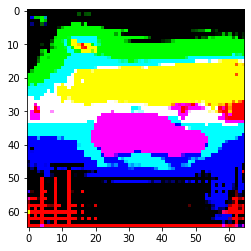

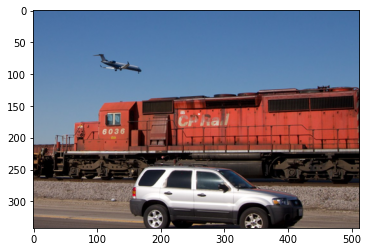

In [16]:
ri, deepfeats = MODEL.run(Image.open('planestrains.jpg'))
deepfeats_reduced = run_pca(deepfeats, 3)
visual_pca(ri, deepfeats_reduced)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape before PCA: (4225, 256)
Shape after PCA: (4225, 3)
(65, 65, 3)


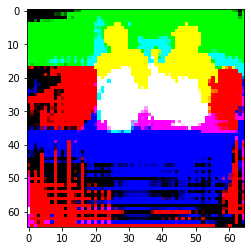

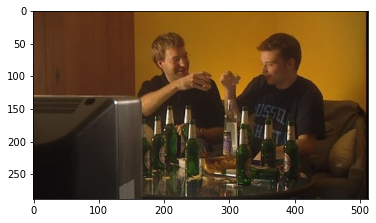

In [17]:
ri, deepfeats = MODEL.run(Image.open('drink.jpg'))
deepfeats_reduced = run_pca(deepfeats, 3)
visual_pca(ri, deepfeats_reduced)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape before PCA: (4225, 256)
Shape after PCA: (4225, 3)
(65, 65, 3)


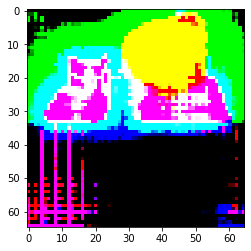

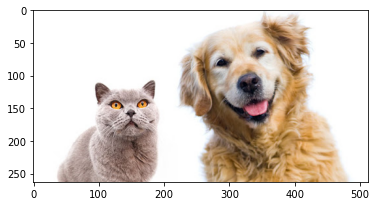

In [18]:
ri, deepfeats = MODEL.run(Image.open('catdog.jpg'))
deepfeats_reduced = run_pca(deepfeats, 3)
visual_pca(ri, deepfeats_reduced)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape before PCA: (4225, 256)
Shape after PCA: (4225, 3)
(65, 65, 3)


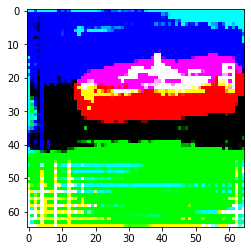

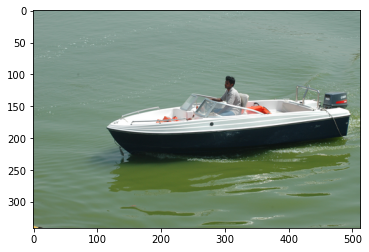

In [19]:
ri, deepfeats = MODEL.run(Image.open('boat.jpg'))
deepfeats_reduced = run_pca(deepfeats, 3)
visual_pca(ri, deepfeats_reduced)

## 3ο Μέρος - Kmeans , PCA

Αφού εκτελέσουμε Principal Component Analysis (PCA) στα βαθιά χαρακτηριστικά ώστε
να ’ριξουμε’ την διάσταση τους σε n = 8, εκτελούμε κατάτμηση με αυτά πλέον σαν είσοδο χρησιμοποιώντας τον αλγόριθμο
k − means. Χρησιμοποιήσετε αριθμό τμημάτων n_clust = 2 για να δυαδικοποιήσετε την εικόνα. (function kmeans_pca())

Τέλος οπτικοποιούμε το αποτέλεσμα ρίχνοτας την διάσταση , για άλλη μια φορα, σε έγχρομη εικόνα. (function visualize_kmeans())

In [20]:
from sklearn.cluster import KMeans

In [21]:
def visualize_kmeans(ri, deepfeats, n=3):
    N = deepfeats.shape[0]*deepfeats.shape[1]
    C = deepfeats.shape[-1]
    X = np.reshape(deepfeats, [N, C])
    Xreduced = PCA(n_components=n).fit_transform(X)
    
    seg_img = np.reshape(Xreduced, [deepfeats.shape[0], deepfeats.shape[1], n])
    plt.imshow(seg_img)
    plt.show()
    plt.imshow(ri)
    plt.show

In [22]:
def kmeans_pca(ri, deepfeats, n=8, n_clust=2):
    N = deepfeats.shape[0]*deepfeats.shape[1]
    C = deepfeats.shape[-1]
    X = np.reshape(deepfeats, [N, C])
    print('Shape before PCA: {}'.format(X.shape))
    Xreduced = PCA(n_components=n).fit_transform(X)
    print('Shape after PCA: {}'.format(Xreduced.shape))
    
    kmeans = KMeans(n_clusters=n_clust)
    kf = kmeans.fit_transform(Xreduced)
    labels = kmeans.labels_
    print("Labels", labels)
    centroids = kmeans.cluster_centers_
    print("Centroids", centroids)
    seg_img = centroids[labels]
    
    seg_img = np.reshape(seg_img, [deepfeats.shape[0], deepfeats.shape[1], n])
    visualize_kmeans(ri, seg_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape before PCA: (4225, 256)
Shape after PCA: (4225, 8)
Labels [0 0 0 ... 0 0 0]
Centroids [[-8.2130566e+00  3.0531770e-01 -3.2461369e-01 -1.9221035e-01
  -2.7192780e-01  1.4952464e-01  2.4509537e-01  7.3157693e-03]
 [ 3.2755253e+01 -1.2176709e+00  1.2946222e+00  7.6657480e-01
   1.0844978e+00 -5.9633642e-01 -9.7748280e-01 -2.9171262e-02]]


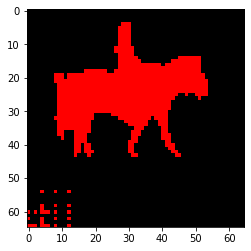

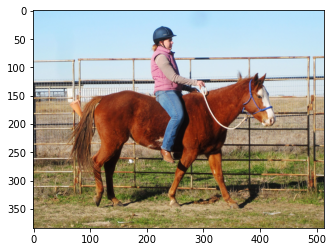

In [23]:
ri, deepfeats = MODEL.run(Image.open('horse.png'))
kmeans_pca(ri, deepfeats)

Shape before PCA: (4225, 256)
Shape after PCA: (4225, 8)
Labels [1 1 1 ... 1 1 1]
Centroids [[ 2.06659698e+01  1.19492829e+00  1.26748681e+00  1.59370124e+00
   2.39823684e-01  3.20235603e-02  1.62764508e-02  4.35627162e-01]
 [-9.85263443e+00 -5.69689929e-01 -6.04284525e-01 -7.59807467e-01
  -1.14336506e-01 -1.52668152e-02 -7.75970472e-03 -2.07686931e-01]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


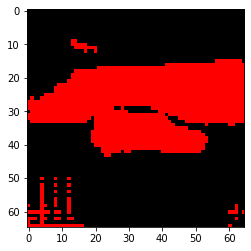

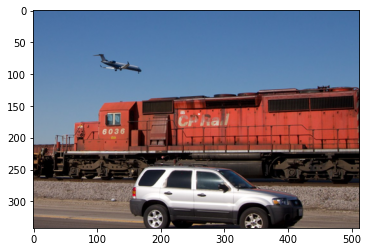

In [24]:
ri, deepfeats = MODEL.run(Image.open('planestrains.jpg'))
kmeans_pca(ri, deepfeats)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape before PCA: (4225, 256)
Shape after PCA: (4225, 8)
Labels [0 0 0 ... 0 0 0]
Centroids [[-6.0927281e+00 -2.7368371e+00 -1.6946500e-02 -4.2570248e-02
   7.1384893e-03 -1.5113579e-01  2.8562812e-02  5.9978861e-02]
 [ 1.8899290e+01  8.4895067e+00  5.2564930e-02  1.3204864e-01
  -2.2139994e-02  4.6881351e-01 -8.8603072e-02 -1.8604676e-01]]


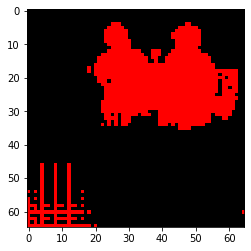

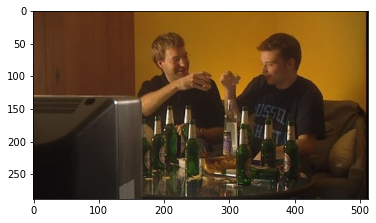

In [25]:
ri, deepfeats = MODEL.run(Image.open('drink.jpg'))
kmeans_pca(ri, deepfeats)

Shape before PCA: (4225, 256)
Shape after PCA: (4225, 8)
Labels [1 1 1 ... 1 1 1]
Centroids [[24.09808     1.8118225   1.104435   -1.7847197   0.22183727 -0.7712998
  -0.9993328   0.35258508]
 [-8.597615   -0.6464153  -0.394034    0.6367451  -0.07914678  0.2751825
   0.3565372  -0.12579483]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


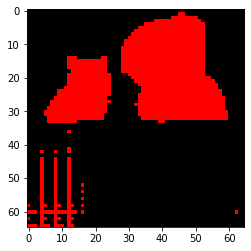

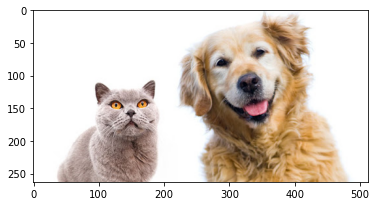

In [26]:
ri, deepfeats = MODEL.run(Image.open('catdog.jpg'))
kmeans_pca(ri, deepfeats)

Shape before PCA: (4225, 256)
Shape after PCA: (4225, 8)
Labels [1 1 1 ... 1 1 1]
Centroids [[30.275688    1.298128    2.287228   -1.8556572   0.31975105  0.34207222
   0.8848793   0.4306707 ]
 [-5.040379   -0.21611325 -0.3807826   0.30893657 -0.0532322  -0.05694867
  -0.14731658 -0.0716983 ]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


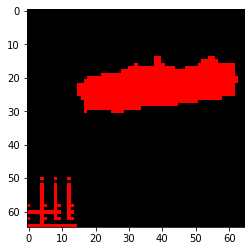

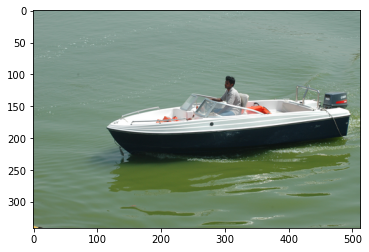

In [27]:
ri, deepfeats = MODEL.run(Image.open('boat.jpg'))
kmeans_pca(ri, deepfeats)